---
title: "PyMC objects using linear regression, seeing the posterior distribution (part 4)"
mathjax: true
toc: true
toc_sticky: true
categories: [data science, statistics]
---

At last, we have come to the end. This is the final post in a series of linear regression posts using [PyMC3](https://docs.pymc.io/), from my reading of [Statistical Rethinking](https://xcelab.net/rm/statistical-rethinking/). [Part 1](https://benslack19.github.io/data%20science/statistics/pymc-linreg-entry01/) set up the problem and explored the package’s objects. [Part 2](https://benslack19.github.io/data%20science/statistics/pymc-linreg_entry02/) interpreted the posterior distribution. [Part 3](https://benslack19.github.io/data%20science/statistics/pymc-linreg_entry03/) predicted *average height* which has its own uncertainty. Here, we'll predict *actual height* which avoids the over-confidence that comes from predicting average height only.

Going deep into each step took some time, but it's helped embed the concepts in my brain. As we've done before, we'll start off duplicating code of the previous posts before we make the final predictions.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns

In [2]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

<IPython.core.display.Javascript object>

**Question**

Ths question come's from the [winter 2020, week 2 homework](https://github.com/rmcelreath/stat_rethinking_2020/blob/main/homework/week02/week02.pdf).

**The weights listed below were recorded in the !Kung census, but heights were not recorded for these individuals. Provide predicted heights and 89% compatibility intervals for each of these individuals. That is, fill in the table below, using model-based predictions.**

| Individual | weight | expected height | 89% interval |
| ------ | ------ | -------- | ---------- |
| 1|  45  |  |
| 2 | 40 |  |  |
| 3 | 65 | |  |
|4  | 31  |  |  |

Let's quickly take a look at the data to get a handle on what we're working with.

In [4]:
d = pd.read_csv("../data/a_input/Howell1.csv", sep=";", header=0)
d2 = d[d.age >= 18]  # filter to get only adults

<IPython.core.display.Javascript object>

# Setting up the variables

In [5]:
# Get the average weight as part of the model definition
xbar = d2.weight.mean()

with pm.Model() as heights_model:

    # Priors are variables a, b, sigma
    # using pm.Normal is a way to represent the stochastic relationship the left has to right side of equation
    a = pm.Normal("a", mu=178, sd=20)
    b = pm.Lognormal("b", mu=0, sd=1)
    sigma = pm.Uniform("sigma", 0, 50)

    # This is a linear model (not really a prior or likelihood?)
    # Data included here (d2.weight, which is observed)
    # Mu is deterministic, but a and b are stochastic
    mu = a + b * (d2.weight - xbar)

    # Likelihood is height variable, which is also observed (data included here, d2.height))
    # Height is dependent on deterministic and stochastic variables
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)

    # The next lines is doing the fitting and sampling all at once.
    trace_m2 = pm.sample(1000, tune=1000, return_inferencedata=False, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


<IPython.core.display.Javascript object>

In [6]:
trace_m2_df = pm.trace_to_dataframe(trace_m2)

<IPython.core.display.Javascript object>

The next set of code gives both the MAP as well as providing a sense of the variance of the data, which is more useful.

In [10]:
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz
az.summary(trace_m2, round_to=3, kind="stats")

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
a,154.600,0.275,154.178,155.055
b,0.903,0.043,0.835,0.970
sigma,5.103,0.195,4.789,5.404


<IPython.core.display.Javascript object>

In [11]:
# Covariance matrix
trace_m2_df.cov().round(3)

,a,b,sigma
a,0.075,0.000,0.000
b,0.000,0.002,-0.000
sigma,0.000,-0.000,0.038


<IPython.core.display.Javascript object>

# Predictions for actual height

We return now to the original problem where we are seeking predictions for actual height. We will produce compatability intervals where we'd expect to see *any* observed height (note how the uncertainty region for $\mu_i$ as shown above is much narrower than where the points are.)

We will do something similar as in the previous post but incorporating $\sigma$.

$\text{height}_i$ ~ Normal($\mu_i, \sigma$)

The repo initially confused me, but I saw that the solution was straightforward after more exploring of functions. I'll spare you most of this exploration, but will put some of my key insights here.

**Function exploration**
<br>
One key realization for me was seeing how the `stats` function for drawing from a normal distribution can have varied mean (`loc`) and standard deviation (`scale`) values. Previously, I had typically used it to get multiple samples from the same mean and standard deviation like this:

In [20]:
stats.norm.rvs(loc=10, scale=2, size=10)

array([ 7.09403309, 12.255019  ,  7.32435791, 10.26594505, 11.79233188,
       12.09804331, 10.84097672, 14.51428249, 14.22362859,  9.25777341])

<IPython.core.display.Javascript object>

I hadn't previously thought to use *different* mean and standard deviations for *each draw*. That is, `loc` and `scale` can be **vectors**. I'll vary the vectors down below for each so that you can see what I mean in the resulting vector.

In [21]:
stats.norm.rvs(
    loc=[1, 1, 1, 10, 10, 10, 20, 20, 20], scale=[0.5, 1, 2, 0.5, 1, 2, 0.5, 1, 2]
)

array([ 0.73038967,  0.37624878,  1.87080349,  9.87713139, 10.7586794 ,
        9.36231624, 20.29745599, 19.36382859, 18.66087831])

<IPython.core.display.Javascript object>

This is when I had my a-ha moment about what to do next. Remember: the posterior distribution that `pymc` outputs produces a different mean and standard deviation in each line.

In [92]:
trace_m2_df.head()

,a,b,sigma
0,154.030585,0.853788,4.989442
1,153.969973,0.861619,5.128790
2,155.111070,0.957769,5.067568
3,154.106523,0.838728,4.961068
4,154.328210,0.863311,5.160797


<IPython.core.display.Javascript object>

We don't need to use a [multivariate normal distribution function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html) but we can instead use the regular (non-multivariate?) version of the [normal distribution function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html). This implementation is more consistent with R code 4.63 which I copied/posted below taken from [McElreath's repo](https://github.com/rmcelreath/rethinking/blob/master/book_code_boxes.txt).

```
## R code 4.63
post <- extract.samples(m4.3)
weight.seq <- 25:70
sim.height <- sapply( weight.seq , function(weight)
    rnorm(
        n=nrow(post) ,
        mean=post$a + post$b*( weight - xbar ) ,
        sd=post$sigma ) )
height.PI <- apply( sim.height , 2 , PI , prob=0.89 )
```

## Making predictions for actual height ($h_i$) at a single weight value

When we input a weight, we can create a vector for `height` that results from the normal distribution that consists of the posterior's parameters. This seems confusing at first, but let's just look at one weight, 45.

Note how the parameters within the `stats.norm.rvs` function mimic McElreath's R code above.

In [93]:
example_weight = 45
h_at_45 = stats.norm.rvs(
    loc=trace_m2_df["a"] + trace_m2_df["b"] * (example_weight - xbar),
    scale=trace_m2_df["sigma"],
)
print(h_at_45)
print("Length of vector: ", len(h_at_45))

[155.7948111  146.56221928 159.43749538 ... 155.33600385 149.83412841
 151.31287874]
Length of vector:  4000


<IPython.core.display.Javascript object>

We have a vector of values for which we can compute summary statistics, including getting a compatibility interval.

In [94]:
# Get 89% compatibility interval
az.hdi(np.array(h_at_45))

array([146.08867804, 162.48740096])

<IPython.core.display.Javascript object>

This seems repetitive to what we did for average height in the last post, but here we've incorporated `sigma` from our posterior distribution. Let's repeat the code for average height and compare what we just did for actual height.

In [95]:
# Vector for average height - note that sigma is not used!
mu_at_45 = trace_m2_df["a"] + trace_m2_df["b"] * (45 - xbar)

<IPython.core.display.Javascript object>

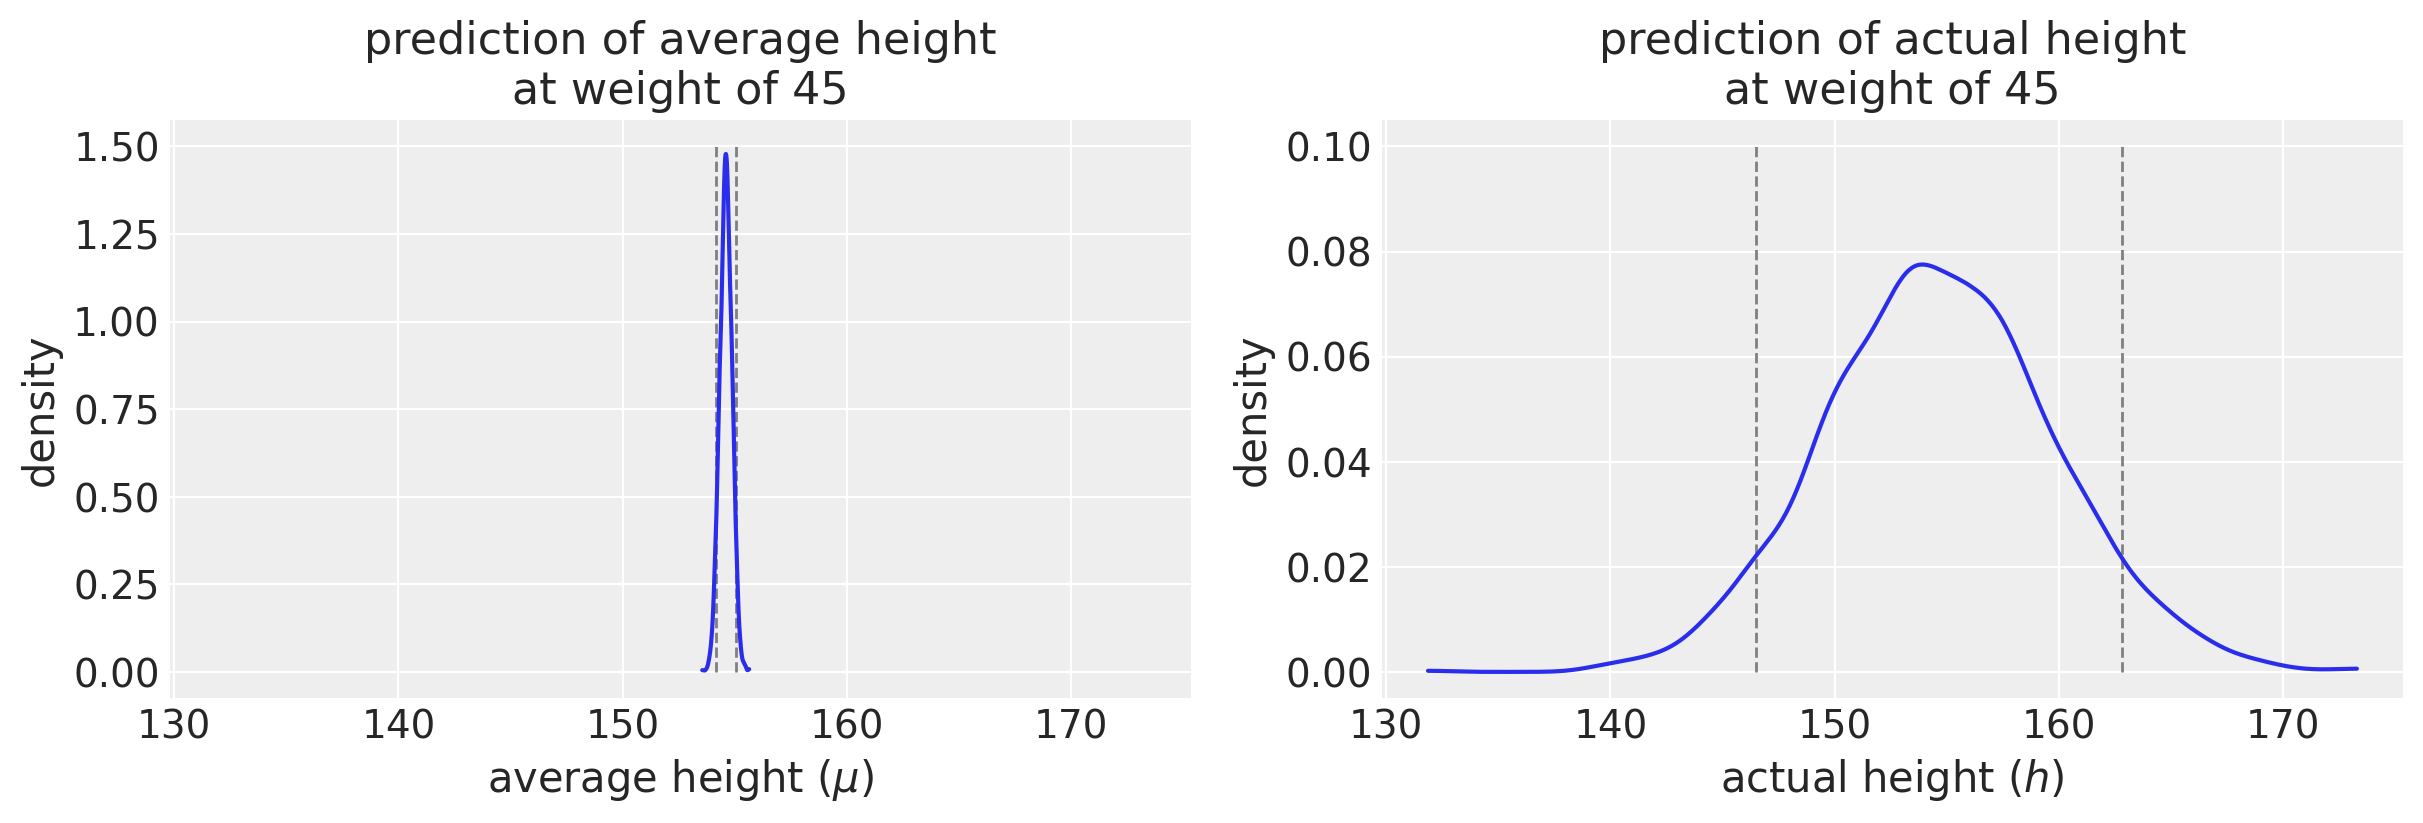

<IPython.core.display.Javascript object>

In [96]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

az.plot_kde(mu_at_45, ax=ax1)
ax1.set_title("prediction of average height\nat weight of 45")
ax1.set_ylabel("density")
ax1.set_xlabel("average height ($\mu$)")
ax1.vlines(
    az.hdi(np.array(mu_at_45)),
    ymin=0,
    ymax=1.5,
    color="gray",
    linestyle="dashed",
    linewidth=1,
)

az.plot_kde(h_at_45, ax=ax2)
ax2.set_title("prediction of actual height\nat weight of 45")
ax2.set_ylabel("density")
ax2.set_xlabel("actual height ($h$)")
ax2.vlines(
    az.hdi(np.array(example_draw)),
    ymin=0,
    ymax=0.1,
    color="gray",
    linestyle="dashed",
    linewidth=1,
)

I am intentionally plotting the x-axis with the same axis limits so that you can appreciate the difference in uncertainty. (Note the difference in the y-axis scale.) We would expect that the probability distribution for average height would be much tighter than the one for actual height. The plots drive that point home visually.

## Making predictions for actual height ($h_i$) at a single weight value

We'll start off by generating a matrix that contains the posterior predictions for actual heights over a range of weights, between 25 and 70 kg. This is similar to what we did for average heights in the last post.

In [81]:
# Input a range of weight values
weight_seq = np.arange(25, 71)

# This is generating a matrix where the predicted h values will be kept
# Each weight value will be its own row
h_pred = np.zeros((len(weight_seq), len(trace_m2_df)))

# Fill out the matrix in this loop
for i, w in enumerate(weight_seq):
    h_pred[i] = stats.norm.rvs(
        loc=trace_m2_df["a"] + trace_m2_df["b"] * (w - xbar), scale=trace_m2_df["sigma"]
    )

# Output the matrix in a dataframe for viewing
df_h_pred = pd.DataFrame(h_pred, index=weight_seq)
df_h_pred.index.name = "weight"
df_h_pred.head()

,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
weight,,,,,,,,,,,,,,,,,,,,,
25,146.819087,131.950216,129.793433,141.425616,134.363193,134.193045,138.625503,127.385217,135.971128,132.278403,...,128.438620,128.187695,140.142773,136.868872,132.564979,140.662170,135.461373,129.179569,133.174905,139.440426
26,136.456664,139.880879,138.150449,144.660997,130.087085,133.466438,134.668864,130.054509,137.989162,144.520142,...,140.724558,122.746829,141.763728,140.855240,138.828098,125.438146,139.518013,145.103823,144.708165,137.155993
27,133.427578,146.873131,148.040623,134.562287,143.913001,141.570235,138.758449,126.249154,139.976170,136.232402,...,132.069314,142.616321,139.039138,144.439965,140.008615,132.783098,136.572733,131.534774,135.076601,145.095471
28,143.316194,130.229996,135.166804,140.417059,143.595620,146.727791,142.071108,135.161632,138.845736,140.713138,...,131.457780,131.502991,140.776164,144.107353,150.544606,144.113096,133.674960,137.908407,131.267668,141.673441
29,142.093570,142.195453,145.842916,144.098927,146.044805,138.547015,148.580323,134.374695,139.463730,141.527401,...,142.074329,145.405100,144.384839,131.004655,150.856133,139.352867,133.089377,139.672434,139.466480,133.085828


<IPython.core.display.Javascript object>

To re-iterate, each row are a weight's sampling of heights as dictated by the posterior distribution of parameters. We can illustrate that graphically.

Text(0.5, 1.0, 'Uncertainty of $h_i$')

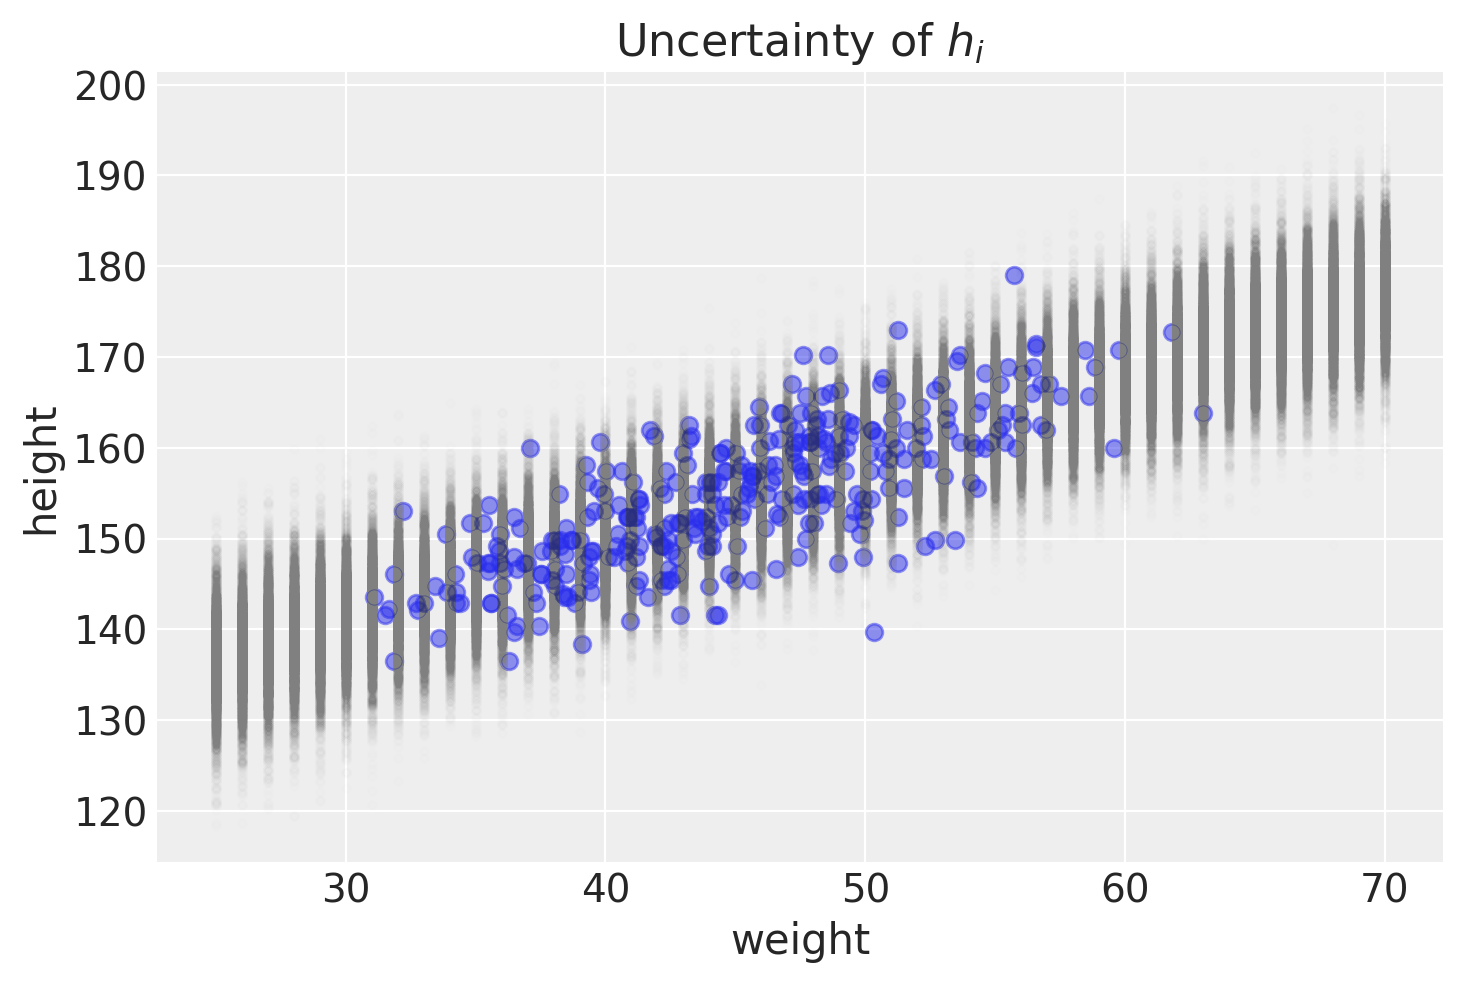

<IPython.core.display.Javascript object>

In [97]:
# Plotting the data as a scatter plot
plt.scatter(d2["weight"], d2["height"], alpha=0.5)
plt.plot(weight_seq, h_pred, "C0.", color="gray", alpha=0.005)
plt.xlabel("weight")
plt.ylabel("height")
plt.title("Uncertainty of $h_i$")

**PyMC method for predictions of actual height**

The above plot helps show the uncertainty for a range of weights after some step-by-step calculations. Not surprisingly, `pymc` and `arviz` can help us get to those steps more quickly. Here's one way to do that.

In [98]:
# Predict heights
# set parameter to 200 to match the notebook example
# could set to 400 to match the samples and nchains
height_pred = pm.sample_posterior_predictive(trace_m2, 200, heights_model)
height_pred

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pymc3/sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


{'height': array([[152.44015719, 143.8660879 , 139.40217284, ..., 156.3123799 ,
         162.99350218, 160.15982149],
        [161.48691291, 152.72929135, 138.60784035, ..., 162.5252433 ,
         167.12620516, 160.8162708 ],
        [154.18712134, 148.66960604, 140.74062707, ..., 165.56777632,
         160.19434841, 157.95943753],
        ...,
        [160.39855129, 147.75720026, 140.01191018, ..., 159.5460152 ,
         153.48386574, 163.72311138],
        [149.698651  , 142.51656198, 145.54450618, ..., 167.74115779,
         165.92839171, 164.0738555 ],
        [159.73732783, 153.56864439, 141.05003146, ..., 166.80582294,
         161.04500287, 160.92227836]])}

<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


Text(0.5, 1.0, 'Uncertainty of $h_i$\n(plotting with the help of arviz)')

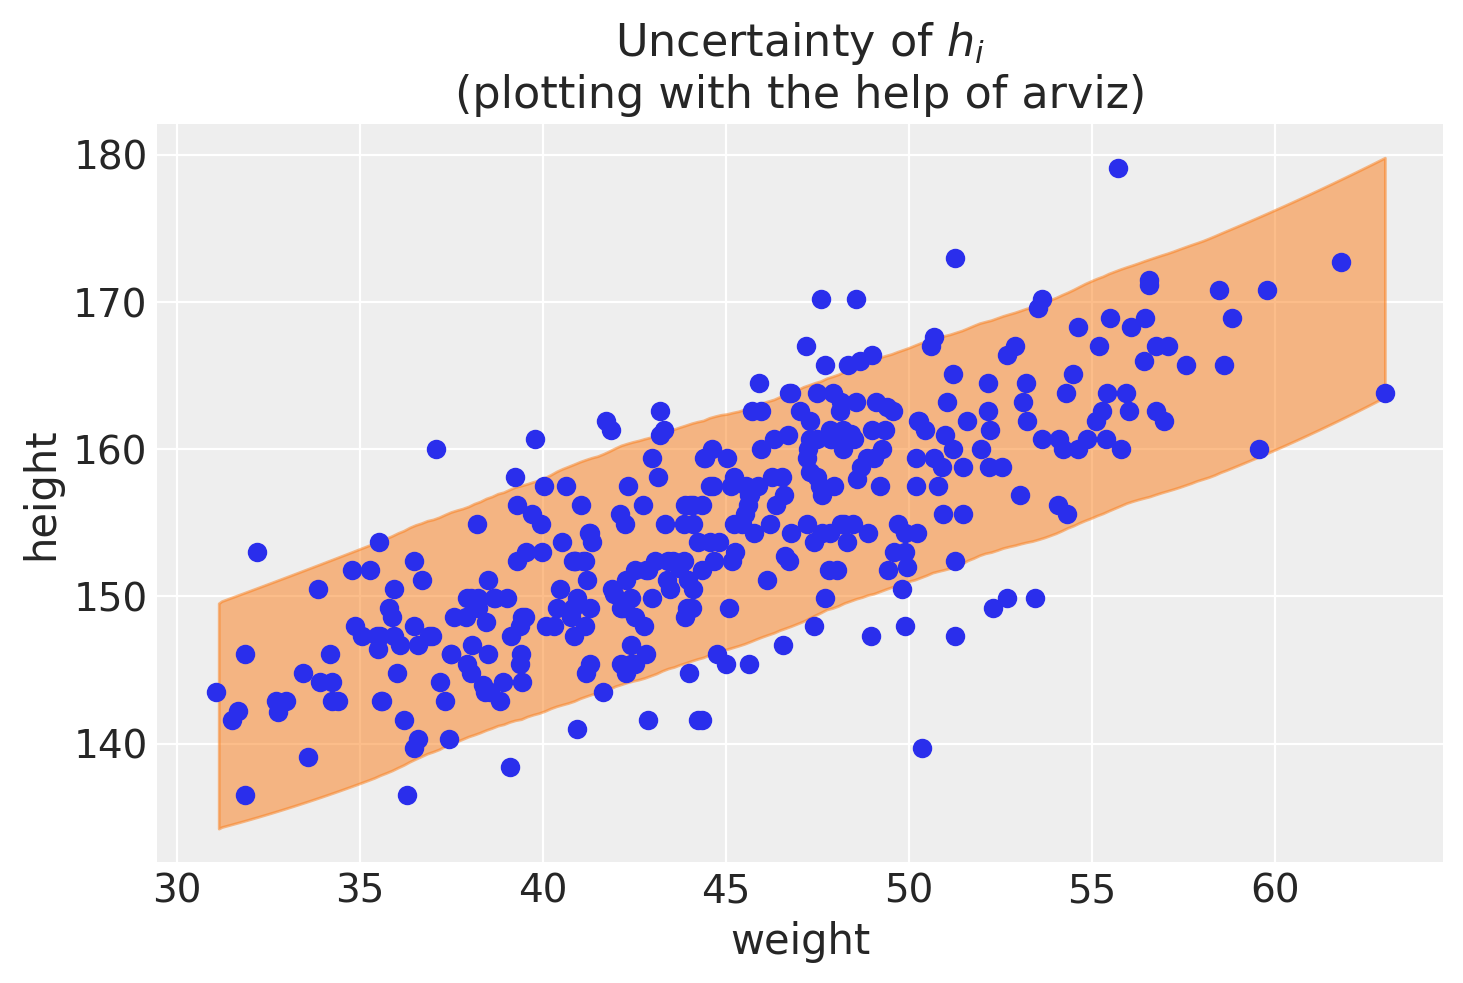

<IPython.core.display.Javascript object>

In [99]:
f, ax1 = plt.subplots()
# ax = az.plot_hdi(weight_seq, mu_pred.T)
az.plot_hdi(d2["weight"], height_pred["height"], ax=ax1)
ax1.scatter(d2["weight"], d2["height"])
ax1.set_xlabel("weight")
ax1.set_ylabel("height")
ax1.set_title("Uncertainty of $h_i$\n(plotting with the help of arviz)")

# The answer to the problem

After all that, we come to the answer, which can be written in a few lines of code.

In [120]:
# Initialize the table
df_answer = pd.DataFrame()
df_answer["individual"] = range(1, 5)
df_answer["weight"] = [45, 40, 65, 31]
df_answer["expected_height"] = None
df_answer["89perc_interval"] = None

<IPython.core.display.Javascript object>

In [137]:
# Fill out the table
for i, weight in enumerate(df_answer["weight"]):

    draw = stats.norm.rvs(
        loc=trace_m2_df["a"] + trace_m2_df["b"] * (weight - xbar),
        scale=trace_m2_df["sigma"],
    )

    df_answer.loc[i, "expected_height"] = "{0:0.2f}".format(draw.mean())
    # .at is for insertion of alist
    # https://stackoverflow.com/questions/26483254/python-pandas-insert-list-into-a-cell
    df_answer.at[i, "89perc_interval"] = "{0:0.2f}, {1:0.2f}".format(
        az.hdi(draw)[0], az.hdi(draw)[1]
    )

# Output the table
df_answer

,individual,weight,expected_height,89perc_interval
0,1,45,154.55,"146.06, 162.41"
1,2,40,150.22,"141.98, 157.86"
2,3,65,172.79,"164.58, 180.99"
3,4,31,141.96,"133.63, 149.96"


<IPython.core.display.Javascript object>

# Summary: A lesson about two kinds of uncertainty

In a series of posts, I took a deep dive into this problem. I initially had not appreciated the two kinds of uncertainty that this problem illustrates. It took me some time to absorb the concept. This was in the McElreath book.

>> **Rethinking: Two kinds of uncertainty.** In the procedure above, we encountered both uncertainty in parameter values and uncertainty in a sampling process. These are distinct concepts, even though they are processed much the same way and end up blended together in the posterior predictive simulation. The posterior distribution is a ranking of the relative plausibilities of every possible combination of parameter values. The distribution of simulated outcomes, like height, is instead a distribution that includes sampling variation from some process that generates Gaussian random variables. This sampling variation is still a model assumption. It’s no more or less objective than the posterior distribution. Both kinds of uncertainty matter, at least sometimes. But it’s important to keep them straight, because they depend upon different model assumptions. Furthermore, it’s possible to view the Gaussian likelihood as a purely epistemological assumption (a device for estimating the mean and variance of a variable), rather than an ontological assumption about what future data will look like. In that case, it may not make complete sense to simulate outcomes.

Appendix: Environment and system parameters

In [138]:
%watermark -n -u -v -iv -w

Last updated: Wed May 19 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

numpy     : 1.20.1
scipy     : 1.6.0
arviz     : 0.11.1
seaborn   : 0.11.1
json      : 2.0.9
pandas    : 1.2.1
matplotlib: 3.3.4
pymc3     : 3.11.0

Watermark: 2.1.0



<IPython.core.display.Javascript object>